In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, PretrainedConfig

import pandas as pd
import torch
import torch.nn.functional as F

In [2]:
data = pd.read_csv("../data/raw/wndp_api.csv")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("wndp-exp/checkpoint-1500/")
model = AutoModelForSequenceClassification.from_pretrained("wndp-exp/checkpoint-1500/")
config = PretrainedConfig.from_pretrained("wndp-exp/checkpoint-1500/")

You are using a model of type distilbert to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [4]:
sample = "found on the ground by window - breathing hard, eyes not open, couldn't stand up, ants covering him, some spazmotic movements of leg, wing, seemed better today. emaciated fledgling with torticollis. Neurologic: torticollis Legs / Feet / Hocks: not using legs. poor prognosis given age, emaciation, and degree of debilitation"

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [6]:
device = torch.device("cpu")
model = model.to(device)

In [7]:
?tokenizer

Signature:     
tokenizer(
    text: Union[str, List[str], List[List[str]]] = None,
    text_pair: Union[str, List[str], List[List[str]], NoneType] = None,
    text_target: Union[str, List[str], List[List[str]]] = None,
    text_pair_target: Union[str, List[str], List[List[str]], NoneType] = None,
    add_special_tokens: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None,
    max_length: Optional[int] = None,
    stride: int = 0,
    is_split_into_words: bool = False,
    pad_to_multiple_of: Optional[int] = None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None,
    return_token_type_ids: Optional[bool] = None,
    return_attention_mask: Optional[bool] = None,
    return_overflowing_tokens: bool = False,
    return_special_tokens_mask: bool = False,
    return_offsets_mapping: bool = False,
    return_length:

In [54]:
def _pre(text, device):
    tokens = tokenizer(text, return_tensors="pt")
    tokens = {k: v.to(device) for k,v in tokens.items()}
    return tokens

def _inf(model, tokens):
    out = model(**tokens)
    return out

def _post(out):
    probs = F.sigmoid(out.logits.squeeze().detach().cpu())
    preds = (probs > 0.5).int()
    labels = [config.id2label[idx] for idx, label in enumerate(preds) if label == 1.0]
    return labels

def infer(model, text):
    tokens = _pre(text, model.device)
    if (len(tokens['input_ids'][0]) <= 512):
        out = _inf(model, tokens)
        pred = _post(out)
        return pred
    else:
        return 'long or short text, working on the bug'

In [55]:
infer(model, sample)

['neurologic_disease', 'nutritional_disease']

In [33]:
data.iloc[7335]

patient_id                    534387
text                             NaN
terms         ['Clinically healthy']
Name: 7335, dtype: object

In [26]:
data.shape

(14044, 3)

In [105]:
pred_df = data[~data.text.isna()]
pred_df = pred_df[pred_df.text.str.len()>1]

In [57]:
%%time
predictions = []
for _,row in pred_df.iterrows():
    #print(row["text"])
    #print("actuals: ", row["terms"])
    pred = infer(model, row["text"])
    #print("predicts: ", pred)
    predictions.append(pred)
    if len(predictions)%100 == 0:
        print(len(predictions))
    #print(len(predictions))
    #print("="*20)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
CPU times: total: 10h 17min 31s
Wall time: 4h 14min 41s


In [58]:
pred_df.iloc[358].text

"Inability to Fly (Finder found patient in gravelpits grounded in Driggs, ID. Called TRC around 11am and BC answered. Finder texted BC photo, and we confirmed it was a GHOW. BC was able to get ahold of Rob C. from IDFG and got verbal permission to transport patient over to WY. BC and SR met finder in Driggs and picked up patient. Finder said he found the patient neither near a road nor by any powerlines. He also said initially there was no blood, but when BC and SR got there there was fresh blood coming from patient's wound.). Fx - Metacarpals (L). Wings / Arms: Patient's L wrist was obviously not being used, and had a compound fracture. Bone was poking through, and bleeding was very fresh. Rads were taken, and there was 2 obvious breaks in the L phalange, if not more. Legs / Feet / Hocks: Small old scrape on R foot 3rd talon. Patient's L wrist was obviously not being used, and had a compound fracture. Bone was poking through, and bleeding was very fresh. 1:00P-Administered 0.1cc Torb 

In [59]:
#aa = data[data.text.str.len() == data.text.str.len().max()].text.values[0]

In [60]:
infer(model, pred_df.iloc[358].text)

'long or short text, working on the bug'

In [106]:
len(predictions)    

14038

In [107]:
#predictions

In [108]:
pred_df.shape

(14038, 3)

In [109]:
pred_df['predictions'] = predictions

In [110]:
pred_df.to_excel('../data/external/predictions.xlsx')

In [111]:
pred_df.set_index('patient_id', inplace = True)
pred_df.head()

,text,terms,predictions
patient_id,,,
1960540,unknown. A9 - orphaned. Feathers / Fur / Skin:...,['Clinically healthy'],[clinically_healthy]
548645,HBC. HBC/NSF. Eyes / Ears / Mouth / Nares: squ...,['Physical injury'],[physical_injury]
1905573,"Dragging leg, circling. Shock, Bleeding from M...",['Physical injury'],[physical_injury]
2741655,Weak. NSF. Eyes / Ears / Mouth / Nares: Eyes s...,['Clinically healthy'],[clinically_healthy]
2637768,Removed / Displaced (Juvenile) - Nest / Nest s...,['Nonspecific'],[nonspecific]


In [113]:
import ast
pred_df['terms'] = pred_df.terms.apply(ast.literal_eval)

In [114]:
from sklearn.metrics import multilabel_confusion_matrix
def add_one_hot(df, column):
    _df = df.copy()
    ohe = (pd.get_dummies(_df[column].apply(pd.Series).stack(), dtype="int")
             .groupby(level=0)
             .sum()
          )
    return pd.merge(_df, ohe, left_index=True, right_index=True)

In [94]:
ydf_true = add_one_hot(pred_df, column='terms')
ydf_pred = add_one_hot(pred_df, column='predictions')
ydf_true.columns = ydf_true.columns.str.lower().str.replace(" ", "_")

In [116]:
ydf_true.shape

(14038, 15)

In [124]:
ydf_true.index.nunique()

14038

In [128]:
cases = ydf_pred.index.unique().tolist()
y = ydf_true.loc[cases]
y.shape

(13942, 15)

In [166]:
columns_list = ['clinically_healthy',
 'dermatologic_disease',
 'gastrointestinal_disease',
 'hematologic_disease',
 'neurologic_disease',
 'nonspecific',
 'nutritional_disease',
 'ocular_disease',
 'physical_injury',
 'respiratory_disease',
 'urogenital_disease']

vis_arr  = multilabel_confusion_matrix(y[columns_list], ydf_pred[columns_list])
vis_arr

array([[[ 9973,   109],
        [   91,  3769]],

       [[13060,    61],
        [   65,   756]],

       [[13076,    38],
        [   48,   780]],

       [[13371,    34],
        [   23,   514]],

       [[11506,   138],
        [  136,  2162]],

       [[12869,   101],
        [  100,   872]],

       [[12394,    72],
        [   77,  1399]],

       [[13066,    61],
        [   47,   768]],

       [[ 8564,   206],
        [  214,  4958]],

       [[12999,   105],
        [   80,   758]],

       [[13504,    27],
        [   32,   379]]], dtype=int64)

In [135]:
# Calculate precision, recall and f1-score per label
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y[columns_list], ydf_pred[columns_list], average=None)

In [136]:
# Print scores  
labels = columns_list
for i in range(len(labels)):
    print(f'Label: {labels[i]}') 
    print(f'Precision: {precision[i]:.3f}')
    print(f'Recall: {recall[i]:.3f}') 
    print(f'F1-score: {f1[i]:.3f}\n')

Label: clinically_healthy
Precision: 0.972
Recall: 0.976
F1-score: 0.974

Label: dermatologic_disease
Precision: 0.925
Recall: 0.921
F1-score: 0.923

Label: gastrointestinal_disease
Precision: 0.954
Recall: 0.942
F1-score: 0.948

Label: hematologic_disease
Precision: 0.938
Recall: 0.957
F1-score: 0.947

Label: neurologic_disease
Precision: 0.940
Recall: 0.941
F1-score: 0.940

Label: nonspecific
Precision: 0.896
Recall: 0.897
F1-score: 0.897

Label: nutritional_disease
Precision: 0.951
Recall: 0.948
F1-score: 0.949

Label: ocular_disease
Precision: 0.926
Recall: 0.942
F1-score: 0.934

Label: physical_injury
Precision: 0.960
Recall: 0.959
F1-score: 0.959

Label: respiratory_disease
Precision: 0.878
Recall: 0.905
F1-score: 0.891

Label: urogenital_disease
Precision: 0.933
Recall: 0.922
F1-score: 0.928



In [133]:
ydf_pred.head()

,patient_id,text,terms,predictions,clinically_healthy,dermatologic_disease,gastrointestinal_disease,hematologic_disease,"long or short text, working on the bug",neurologic_disease,nonspecific,nutritional_disease,ocular_disease,physical_injury,respiratory_disease,urogenital_disease
0,1960540,unknown. A9 - orphaned. Feathers / Fur / Skin:...,[Clinically healthy],[clinically_healthy],1,0,0,0,0,0,0,0,0,0,0,0
1,548645,HBC. HBC/NSF. Eyes / Ears / Mouth / Nares: squ...,[Physical injury],[physical_injury],0,0,0,0,0,0,0,0,0,1,0,0
2,1905573,"Dragging leg, circling. Shock, Bleeding from M...",[Physical injury],[physical_injury],0,0,0,0,0,0,0,0,0,1,0,0
3,2741655,Weak. NSF. Eyes / Ears / Mouth / Nares: Eyes s...,[Clinically healthy],[clinically_healthy],1,0,0,0,0,0,0,0,0,0,0,0
4,2637768,Removed / Displaced (Juvenile) - Nest / Nest s...,[Nonspecific],[nonspecific],0,0,0,0,0,0,1,0,0,0,0,0


In [169]:
labels  = columns_list
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    #print(confusion_matrix)
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

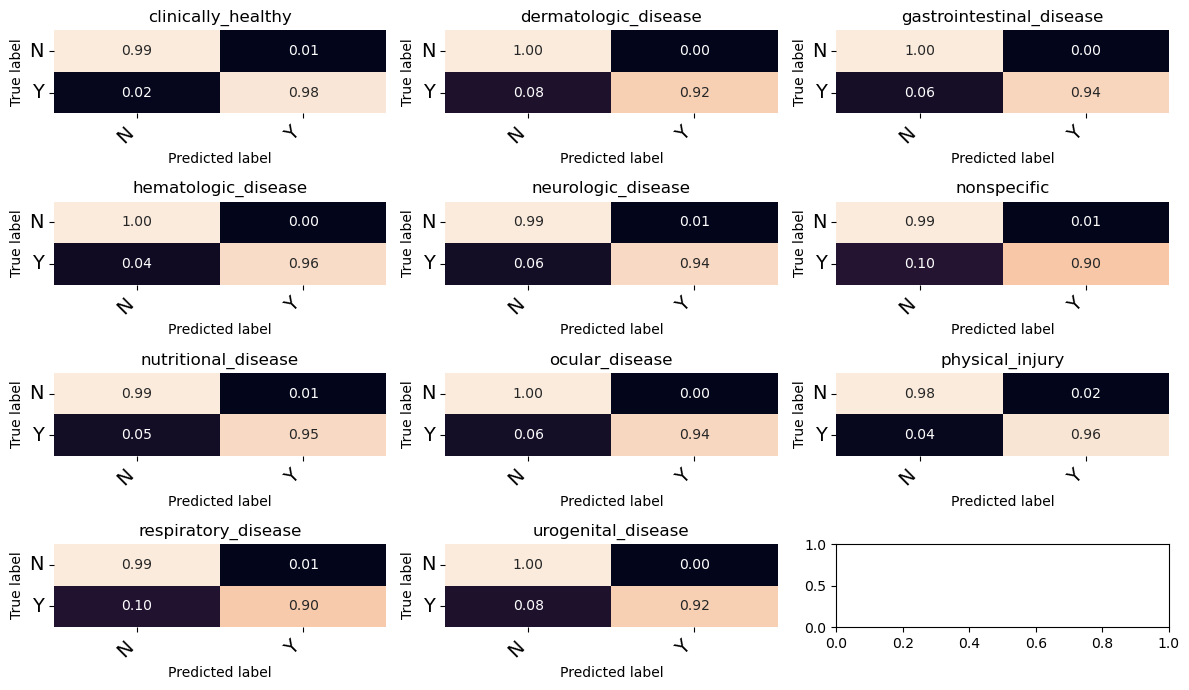

In [170]:
fig, ax = plt.subplots(4, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.savefig('../reports/figures/confusion_matrix.png', dpi = 600)
plt.show()